# [George McNinch](http://gmcninch.math.tufts.edu) Math 87 - Spring 2025

# Week 4

# Network flows and linear programming 


So far we have looked at a few examples of linear programs. The key step in modeling these
problems is to write down the program itself.

As we saw, for simple programs, such as the carpenter problem, we can figure it out geometrically.
There were only a few variables and a few obvious constraints and it was easy to check all the
“vertices.”

Let's consider a more complex problem.


# Network flows

We are going to consider some more complex situations for which we will
use a *network flow* to help produce the corresponding linear program.

Let’s recall that a *directed graph* is a pair $G = (V,E)$ where the
elements of the set $V$ are the *vertices* of the graph, and where
$E ⊂ V × V$ are the *edges* of $G$. Thus, an element $e = (a,b) ∈ E$
represents a directed edge from vertex $a$ to vertex $b$.

We can produce diagrams for directed graphs using the program
[`graphviz`](https://graphviz.org/) (and a corresponding python library
[`python-graphviz`](https://github.com/xflr6/graphviz)).

(you can install graphviz using
```
george@valhalla:~$ source .venv/bin/activate
(.venv) george@valhalla:~$ pip install graphviz
```
That only installs the *python* interface for `graphviz`. You also need to install the `graphviz program itself. I do this via

```
george@valhalla:~$ sudo apt install graphviz
```
You can read about [https://graphviz.org/download/https://graphviz.org/download/installation for various platforms here](https://graphviz.org/download/)


)

Let’s look at a simple graph:

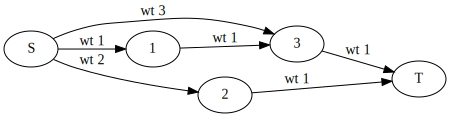

In [2]:
from graphviz import Digraph as GVDigraph

dot = GVDigraph("example")
dot.attr(rankdir='LR')

# vertices are just labeled by a string
vertices = ['S', '1', '2', '3', 'T']

# edges join two vertices, and have an attached numerical *weight*

edges = [{ 'from': 'S',
           'to': '1',
           'weight': 1
         },
         { 'from': 'S',
           'to': '2',
           'weight': 2
         },
         { 'from': '1',
           'to': '3',
           'weight': 1
         },
         { 'from': 'S',
           'to': '3',
           'weight': 3
         },
         { 'from': '2',
           'to': 'T',
           'weight': 1,
           'lower': 10,
           'label': "constraint"
         },
         { 'from': '3',
           'to': 'T',
           'weight': 1,
           'lower': 9,
           'label': "constraint"
         }
        ]

for v in vertices:
  dot.node(v)
  
for e in edges:
  dot.edge(e["from"],e["to"],label=f"wt {e['weight']}")
  
dot

We view each edge as a *variable* (*"what quantity flows through this edge?"*).

The weights determine the linear function to be *optimized*; we represent this linear
function as a (row) vector `c`, the *objective vector*.

Each *internal vertex* determines a **conservation law**: at each internal vertex, the sum of the value of the incoming variables must be the same as the sum of the value of the outgoing variables.

In [5]:
import numpy as np
import math

def sbv(index,size):
    return np.array([1.0 if i == index else 0.0 for i in range(size)])

# objective vector 
def objective(edges):
    return sum([e["weight"]*sbv(edges.index(e),len(edges)) for e in edges])


In [9]:
2*sbv(2,18) -3* sbv(3,18)

array([ 0.,  0.,  2., -3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

Now let's identify incoming and outgoing edges from a given vertex, and in particular decide whether a vertex is a *source* or a *sink*.

In [12]:
def getIncoming(vertex,edges):
    return [ e for e in edges if e["to"] == vertex ]
    
def getOutgoing(vertex,edges):
    return [ e for e in edges if e["from"] == vertex ] 

def isSource(vertex,edges):
    return getIncoming(vertex,edges) == []

def isSink(vertex,edges):
    return getOutgoing(vertex,edges) == []

def interiorVertices(vertices,edges):
    return [ v for v in vertices if not( isSource(v,edges) or isSink(v,edges) ) ]


Now let's create the conservation law for a vertex. It will be given by a row vector.

The *matrix* of conservation laws has a row determined by the conservation law for each interior vertex.

In [13]:
def conservationLaw(vertex,edges):
    ii = sum([ sbv(edges.index(e),len(edges)) for e in getIncoming(vertex,edges) ])
    oo = sum([ sbv(edges.index(e),len(edges)) for e in getOutgoing(vertex,edges) ])
    return ii - oo

def conservationMatrix(vertices,edges):
    return np.array([conservationLaw(v,edges) for v in interiorVertices(vertices,edges) ])

conservationMatrix(vertices,edges)

array([[ 1.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  1.,  1.,  0., -1.]])

Now let's make the matrix and vector defining the *inequality constraints*. These are specified by the `upper` and `lower` fields in the edge dictionary (which may be omitted)

In [15]:

def lowerBound(edge):
    if 'lower' in edge.keys():
        return edge['lower']
    else:
        return -math.inf

def upperBound(edge):
    if 'upper' in edge.keys():
        return edge['upper']
    else:
        return math.inf

def ineqConstraints(edges):
    m = np.array([*[ sbv(edges.index(e),len(edges)) 
                     for e in edges 
                     if not upperBound(e) == math.inf ],
                  *[ -sbv(edges.index(e),len(edges))
                     for e in edges
                     if not lowerBound(e) == -math.inf ]
                 ])
    
    b = np.array([ *[ upperBound(e) 
                      for e in edges 
                      if not upperBound(e) == math.inf],
                   *[ -lowerBound(e) 
                      for e in edges 
                      if not lowerBound(e) == -math.inf]
                 ])

    return m,b

ineqConstraints(edges)

(array([[-0., -0., -0., -0., -1., -0.],
        [-0., -0., -0., -0., -0., -1.]]),
 array([-10,  -9]))

We can now run the corresponding linear program. Let's write a function to do this whose inputs are
`vertices` and `edges`

In [16]:
from scipy.optimize import linprog


def reportEdge(edge):
    if "label" in edge.keys():
        return f"{edge['label']} ({edge['from']} --> {edge['to']})"
    else:
        return f"     ({edge['from']} --> {edge['to']})"
 

def runNetworkFlow(vertices,edges,maximize=False):
    obj = objective(edges)
    Aeq = conservationMatrix(vertices,edges)
    Aub,bub = ineqConstraints(edges)

    beq = np.zeros(len(interiorVertices(vertices,edges)))

    if maximize:
        lr  = linprog((-1)*obj,
                      A_eq = Aeq,
                      b_eq = beq,
                      A_ub = Aub,..
                      b_ub = bub
                     )

        optimal_value = -lr.fun
    else:
        lr  = linprog(obj,
                      A_eq = Aeq,
                      b_eq = beq,
                      A_ub = Aub,
                      b_ub = bub
                     )
        optimal_value = lr.fun
    if lr.success:
        return [ f"optimal value: {optimal_value}" ] + [ (reportEdge(e), lr.x[edges.index(e)]) for e in edges] 
    else:
        print("Linear program failed")
        
runNetworkFlow(vertices,edges)

['optimal value: 57.0',
 ('     (S --> 1)', np.float64(9.0)),
 ('     (S --> 2)', np.float64(10.0)),
 ('     (1 --> 3)', np.float64(9.0)),
 ('     (S --> 3)', np.float64(0.0)),
 ('constraint (2 --> T)', np.float64(10.0)),
 ('constraint (3 --> T)', np.float64(9.0))]

----

Restaurant Example
------------------

Suppose that you are opening a new restaurant and need to make sure you have enough clean
tablecloths to meet expected demand in the first week. On each day, you can buy new tablecloths for \\$ 5. Used tablecloths can be laundered and returned the next day for \\$2 or the following day for \$1.

Your expected tablecloth demands are:

| Day                |   1 |   2 |   3 |   4 |   5 |   6 |   7 |
| :--                | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| tablecloths needed |  10 |  10 |  15 |  20 |  40 |  40 |  30 |

Let’s try to formulate a linear program to minimize the costs.

Let's name the quantities from the table.
- $t_i$ = expected # of tablecloths required on day $i$.

Now introduce variables:

- $b_i$ = # tablecloths bought on day $i$, $1 ≤ i ≤ 7$.
- $f_i$ = # dirty tablecloths sent to fast laundry on day $i$
- $s_i$ = # dirty tablecloths sent to slow laundry on day $i$

First, let’s write down the objective (assuming we only care about week 1):

The goal is to minimize the quantity
$$5 \sum_{i=1}^7 b_i + 2\sum_{i=1}^6 f_i + \sum_{i=1}^5 s_i$$

What are the constraints? On day $i$, we must have at least $t_i$ tablecloths available.

- day 1

  - we need enough tablecloths for day 1, so 
  $$t_1 \le b_1$$

- day 2

  - demand must be met from purchases on day 2, plus surplus from day 1, plus fast laundry from day 1.
    note that the *use* on day 1 is equal to $f_1 + s_1$ and thus $b_1 - f_1 - s_1$ 
    counts the surplus from day 1. So we need
    
  $$t_2 \le b_2  + (b_1 - f_1 - s_1) + f_1$$

- day 3

  - demand must again be met from purchases on day 3, plus leftover from the previous days, plus
    those laundered from the fast service on day 2, and those laundered via the slow service on day 1.
    The total used in the first two days is equal to $f_1 + s_1 + f_2 + s_2$, so the surplus
    from the first two days is $b_1 + b_2 - f_1 - s_1 - f_2 - s_2$. So we need
  $$t_3 \le b_3 + (b_1 + b_2 - f_1 - s_1 - f_2 - s_2) + f_2 + s_1$$

etc.

This becomes increasingly hard to keep track of and formulate.

So, instead, we build what’s called a network model and we track the flow of tablecloths!



## Describing the network flow

We represent the *source* of tablecloths by a vertex.
And for each day, we form a vertex representing `clean` tablecloths, and a vertex representing
`used` tablecloths.

Remember that edges in our graph correspond to *variables* (which we aren't going to name).

- For each day, we create an edge connecting the source of tablecloths with the vertex representing the `clean` tablecloths for the day. These edges represent *purchase* of tablecloths.

- For each day, we create an edge connecting vertex for the `clean` tablecloths for the day with the vertex for the `used` tablecloths for the day. These edges represent *use*, and their corresponding variables must satisfy the lower bound indicated by *expected tablecloth demand*.

- For each day (except day 7), we create an edge connecting the vertex for the `clean` tablecloths for the day with the vertex for the `clean` tablecloths of the subsequent day. These edges represent *carry-over* of unused tablecloths.

- For each day (except day 7) we create edge conntecting the vertex for the `used` tablecloths for the day with the vertex for the `clean` tablecloths of the subsequent day. These edges represent use of the *fast laundry*.

- For each day (except days 6 and 7) we create edge conntecting the vertex for the `used` tablecloths for the day with the vertex for the `clean` tablecloths of two days later. These edges represent use of the *slow laundry*.

Here is the code:

In [18]:
# vertices for restaurant example

# usage requirements

tt = {1: 10,  
      2: 10,  
      3: 15,  
      4: 20,  
      5: 40,  
      6: 40,  
      7: 30 
     }


source = [ 'source' ]
cleanVert = [ f"day {n} clean" for n in range(1,8) ]
usedVert = [ f"day {n} used" for n in range(1,8) ]

# in python, addition of lists amounts to concatentation
# e.g. [1,2] + [3,4] = [1,2,3,4].
#
restaurant_vertices = source + cleanVert + usedVert


edges_from_source = [ {"from": 'source',
                       "to": f"day {n} clean",
                       'label': "purchase",
                       "weight": 5} 
                       for n in range(1,8)
                    ] 

edges_carryover = [ {"from": f"day {n} clean",
                     "to":   f"day {n+1} clean",
                     "label": "carryover",
                     "weight": 0
                    }
                    for n in range(1,7)
                    ]

edges_use = [ { "from": f"day {n} clean",
                "to":   f"day {n} used",
                "label": "tablecloth use",
                "weight": 0,
                "lower": tt[n]
                }
                for n in range(1,8)
            ]
edges_fast_laundry = [ { "from": f"day {n} used",
                         "to": f"day {n+1} clean",
                         "label": "fast laundry",
                         "weight": 2
                       }
                       for n in range(1,7)
                     ]

edges_slow_laundry = [ { "from": f"day {n} used",
                         "to":   f"day {n+2} clean",
                         "label": "slow laundry",
                         "weight": 1
                         }
                        for n in range(1,6)
                    ]

restaurant_edges = edges_from_source + edges_carryover + edges_use + edges_fast_laundry + edges_slow_laundry


In [20]:
[1,2] + ["a", "b"]

[1, 2, 'a', 'b']

As before, we can use `graphviz` and the `vertices` and `edges` we have defined to produce an image
of the graph.

(*To make the graph more aesthetic, we have organized the vertices into `subgraphs`...*)

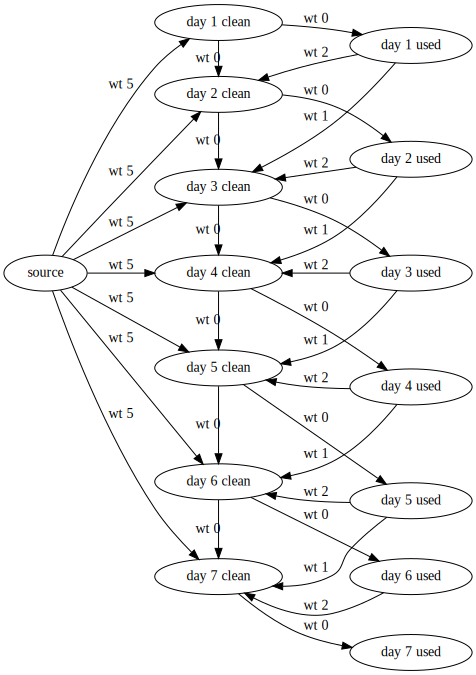

In [21]:
from graphviz import Digraph as GVDigraph

dot = GVDigraph("example")
dot.attr(rankdir='LR')

#for v in restaurant_vertices:
#  dot.node(v)

dot.node('source')

with dot.subgraph(name='clean') as c:
    c.attr(rank='same')
    for vertex in cleanVert:
        c.node(vertex)

with dot.subgraph(name='used') as c:
    c.attr(rank='same')
    for vertex in usedVert:
        c.node(vertex)


for e in restaurant_edges:
  dot.edge(e["from"],e["to"],label=f"wt {e['weight']}")
  
dot

Now, the `runNetworkFlow` function we used earlier can be invoked on the vertices and edges for this
restaurant problem.

THe result describes the number of tablecloth purchases that should be made, as well as the use of fast and slow laundry in order to minimize the costs (the minimal costs are $435).

In [22]:
runNetworkFlow(restaurant_vertices,restaurant_edges)

['optimal value: 435.0',
 ('purchase (source --> day 1 clean)', np.float64(10.0)),
 ('purchase (source --> day 2 clean)', np.float64(10.0)),
 ('purchase (source --> day 3 clean)', np.float64(5.0)),
 ('purchase (source --> day 4 clean)', np.float64(15.0)),
 ('purchase (source --> day 5 clean)', np.float64(0.0)),
 ('purchase (source --> day 6 clean)', np.float64(0.0)),
 ('purchase (source --> day 7 clean)', np.float64(0.0)),
 ('carryover (day 1 clean --> day 2 clean)', np.float64(0.0)),
 ('carryover (day 2 clean --> day 3 clean)', np.float64(0.0)),
 ('carryover (day 3 clean --> day 4 clean)', np.float64(0.0)),
 ('carryover (day 4 clean --> day 5 clean)', np.float64(5.0)),
 ('carryover (day 5 clean --> day 6 clean)', np.float64(0.0)),
 ('carryover (day 6 clean --> day 7 clean)', np.float64(0.0)),
 ('tablecloth use (day 1 clean --> day 1 used)', np.float64(10.0)),
 ('tablecloth use (day 2 clean --> day 2 used)', np.float64(10.0)),
 ('tablecloth use (day 3 clean --> day 3 used)', np.float64

----

The **takeaway** here is that "network flow" graphs can be a useful tool to formulate linear programs. 
Here is another example.


Grocery example
===============

Let's look at another example.

A fruit wholesaler buys and sells apples according to the following prices and demand:

| Month                 | Aug  | Sep | Oct | Nov | Dec | Jan | Feb | Mar | Apr | May | Jun | Jul |
|:-----                 | --:  | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: |
| price/kg  from grower | 0.80 | 0.55| 0.55| 0.65| 0.75| 0.85| 0.95| -   | -   | -   | -   | -   |
| sale price/kg         | 0.90 | 0.65| 0.65| 0.85| 1.00| 1.00| 1.20| 1.20| 1.20| 1.00| 0.80| 0.80|
| demand in 1000kg       | 10   | 15  | 15  | 15  | 13  | 10  | 10  | 10  | 9   | 7   | 5   | 5   |

The wholesaler can store 50,000kg at a cost of \$0.025 per kg per month. Unlimited supplies are available from the grower between September and January, but only 15,000kg are available in August and February and none during the rest of the year. 

We consider the profit for a year (12 months), from August to the next July. We suppose that there are *no* apples to carry over from the previous month -- we begin with no apples.

Goal: maximize the profit!

---------------


Now let's formulate the linear program.

What parameters are we tracking?

- `g_m` \# kg bought from the grower for month `m`

- `s_m` \# kg *stored* for month `m`

- `d_m` \# kg *sold* in month `m`

All of our variables are assumed to be non-negative: `g_m >= 0`, `s_m >= 0`, `d_m >= 0` for all months `m`.

We've been told the following:

> Unlimited supplies are available (from the grower) from September to January 
> but only 15,000kg are available in
> August and February and none during the rest of the year. 

This gives us upper bounds on the `g_m` variables; for example
`g_aug <= 1500`.

We've also been told:

> The wholesaler can store 50,000kg at a cost of \$0.025 per kg per month.

This yields the upper bound
- `s_m <= 50000` for each month `m`.

Now, we know from table the demand for each month. Remember what we are doing: with the linear program, we are trying to decide the optimal values of our decision variables -- i.e. how many apples do we buy each month? and how many apples do we store each month? According to the model, the number of apples we expect to *sell* depends on these choices (via the conservation laws). So to be sensible, our model must view the anticipated demand (listed in the table) as an **upper bound** for the amount we can sell. More precisely, we should impose the constraint that the number $d_i$ of ``kg`` of apples delivered to customers is $\le$ the anticipated demand for each month. 
(Of course, this is what the label on the diagram indicates! Here I'm trying to explain why we have chosen that labeling).

So for example this leads to the upper bound
`d_sep <= 15000`

The parameters `d_m`, `s_m` and `g_m` are going to represent edges in a network flow graph. 

- `g_m` corresponds to an edge connecting vertex representing the `grower` and the vertex representing month `m`.
- `s_m` corresponds to an edge connecting the vertex representing a month and the vertex representing the subsequent month.
- `d_m` corresdonds to an edge connecting the vertex representing a month and the vertex representing `demand`

Conservation:

The internal nodes of our network flow diagram correspond to months. The arrow "going in" to the node
amount to available apples, and they correspond to purchases `g_m` and storage `s_m`. The arrows going out correspond
to storage (`s_m`) and to apples delivered to customers (`d_m`). Thus, we must have

- `s_aug + d_aug - g_aug = 0`
- `s_sep + d_sep - g_sep - s_aug = 0`.
- `s_oct + d_oct - g_oct - s_sep = 0`.
- etc...

Objective:

The objective function represents profit, and each variable has some contribution to objective/profit function. We spend money through apple purchases and through storage costs, and these costs have negative values. We get money through apple sales, and these costs have positive value. 

Each month contributes to the objective function; for example, the contribution of `nov` is
`-0.65 g_nov - 0.025 s_nov + .85 d_nov`

Of course, the objective function is the *sum* of all 12 of these monthly contributions.

Let's represent this graph by data structures in `python`:

In [ ]:

# price in the indicated month for purchases from the grower 
# in $/kg
# infinite price indicates unavailability
price_grower = { 'aug': 0.80,
                 'sep': 0.55,
                 'oct': 0.55,
                 'nov': 0.65,
                 'dec': 0.75,
                 'jan': 0.85,
                 'feb': 0.95,
                 'mar': 0,     # the prices is zero because no product is available.
                 'apr': 0,     # we could mark the price as math.inf, but that is awkward for the
                 'may': 0,     # objective function.
                 'jun': 0,
                 'jul': 0
               }

# price in the indicated moth for sales to customers
# in $/kg
sales_price = { 'aug': 0.90,
                'sep': 0.65,
                'oct': 0.65,
                'nov': 0.85, 	
                'dec': 1.00, 	
                'jan': 1.00, 
                'feb': 1.20, 	
                'mar': 1.20, 	
                'apr': 1.20, 	
                'may': 1.00, 	
                'jun': 0.80, 	
                'jul': 0.80
              }

# demand for apples in the indicated month
# in 1000*kg
demand = { 'aug': 10,
           'sep': 15,
           'oct': 15,
           'nov': 15, 	
           'dec': 13, 	
           'jan': 10, 
           'feb': 10, 	
           'mar': 10, 	
           'apr':  9, 	
           'may':  7, 	
           'jun':  5, 	
           'jul':  5
           }

months = ['aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul' ]

def next_month(m):
    i = months.index(m)
    return months[(i+1) % 12]

# compute the # of kg available from grower in the indicated month
def available(m):
    i = months.index(m)
    if (months.index('sep') <= i) and (i <= months.index('jan')):
        return math.inf
    elif m in ['aug','feb']:
        return 15000
    else:
        return 0

# vertices of the graph
grocery_vertices = [ 'grower' ] + months + [ 'demand' ]

# edges of the graph

purchase_edges = [ { 'from': 'grower',
                     'to': m,
                     'weight': (-1)*price_grower[m],
                     'label': 'purchase from grower',
                     'upper': available(m)
                   }
                  for m in months 
                 ]

storage_edges = [ { 'from': m,
                    'to': next_month(m),
                    'weight': -0.025,
                    'upper': 50000,
                    'label': 'storage'
                  }
                 for m in months
                 if m != 'jul'
                ]

demand_edges = [ {'from': m,
                  'to': 'demand',
                  'weight': sales_price[m],
                  'label': 'sales to customers',
                  'upper': demand[m]*1000
                 }
                for m in months
               ]

grocery_edges = purchase_edges + storage_edges + demand_edges

Now let's draw the graph using `graphviz`. (Once again, we sort the vertices a bit for aesthetic reasons).

In [ ]:
from graphviz import Digraph

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

dot = Digraph('fruit wholesaler model')

dot.attr(rankdir='LR')
dot.node('grower')

with dot.subgraph(name='months') as c:
    c.attr(rank='same')
    for month in months:
        c.node(month)
    
dot.node('demand')

for e in grocery_edges:
  dot.edge(e["from"],e["to"],label=f"wt {e['weight']}")
  
dot

#dot.format='png'
#dot.render()

Finally, we can invoke our function `runNetworkFlow` on the vertices and edges for this graph.

In this case, the linear program should be `maximizing` the objective function, so we pass the flag `maximize=True`.

If you look back at the definition of `runNetworkFlow`, you'll see this causes the `scipy.optimize`
function `linprog` to be invoked with the *negative* of the objective vector, since the implementation of `linprog` *minimizes* its objective function.

In [ ]:
runNetworkFlow(grocery_vertices,grocery_edges,maximize=True)